In [40]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import math
import scipy as sp
import sys
from sys import getsizeof
from numpy.polynomial.chebyshev import Chebyshev as Cheb
from numpy.random import rand
from scipy.signal import tukey
import time
import corner
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

sns.set_context('talk')
sns.set_style('ticks')

import torch.nn.functional as F

from nflows.distributions import StandardNormal
from nflows import transforms
from nflows.nn.nets import ResidualNet
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms as T

# Theory

## Intro Machine Learning

## Neural Networks

## Generative Models

## Normalising Flows

## Reproducibility

Setting the seed for the random number generators, this allows us to create reproduceable results using this particular seed, rather than it being randomised every time


In [41]:
seed =  1234

np.random.seed(seed)
torch.random.manual_seed(seed)

## Define model

The following cell comes from the normalising flows tutorial

In [42]:
# Defining the base class to build the neural network from, the neural networks inherets from nn.module (the base class for all neural networks in pytorch)
class ImprovedRealNVP(torch.nn.Module):
    
    #The __init__ function is executed when the class is initiated, It allows us to input properties of the class
    def __init__(self, 
    
                n_dims=None, # Number of inputs for the distribution to learn
                n_transforms=None, # Number of transforms to use
                n_layers_per_transform=None, # Number of layers in the neural network used for each transform
                n_neurons_per_layer=None, # Number of neurons per layer in the neural network
                n_conditional_inputs=None): # Chosing the conditions for which to base the new sampels(?)
        
        # Initialising the base class, nn.module along with the first __init__ for our ImprovedRealNVP Class.
        # Without super().__init__() we only inherent the methods of the base class, we need to use super init to run the init of the base class
        super().__init__() 
        
        # Define function for creating the neural network
        def create_net(in_features, out_features):
                return ResidualNet(
                    in_features,
                    out_features,
                    hidden_features=n_neurons_per_layer,
                    context_features=n_conditional_inputs,
                    num_blocks=n_layers_per_transform,
                    activation=F.leaky_relu,
                    dropout_probability=False,
                    use_batch_norm=True
                    )
        
        def create_linear_transform():
            return transforms.CompositeTransform([
                transforms.RandomPermutation(features=n_dims),
                transforms.LULinear(n_dims, identity_init=True,
                                    using_cache=False)
            ])

        # Make an alternating mask. If the value is one, the parameter is updated
        # if it <0 then it is used as the input to the NN
        mask = torch.ones(n_dims)
        mask[::2] = -1

        transforms_list = []
        for i in range(n_transforms):
            transforms_list.append(create_linear_transform())
            transform = transforms.AffineCouplingTransform(
                mask=mask, transform_net_create_fn=create_net
            )
            transforms_list.append(transforms.BatchNorm(features=n_dims))
            mask *= -1
            transforms_list.append(transform)

        self.transform = transforms.CompositeTransform(transforms_list)
        self.distribution = StandardNormal([n_dims])

    def forward(self, x, context=None):
        """
        Apply the forward transformation and return samples in the latent
        space and log |J|
        """
        return self.transform.forward(x, context=context)

    def inverse(self, z, context=None):
        """
        Apply the inverse transformation and return samples in the
        data space and log |J| (not log probability)
        """
        return self.transform.inverse(z, context=context)

    def log_prob(self, x, context=None):
        """
        Computes the log probability of the inputs samples by applying the
        transform.
        """
        z, logabsdet = self.transform(x, context=context)
        log_prob = self.distribution.log_prob(z)
        return log_prob + logabsdet

    def sample(self, n, context=None):
        """
        Produces N samples in the data space by drawing from the base
        distribution and the applying the inverse transform.
        """
        z = self.distribution.sample(n)
        samples, _ = self.transform.inverse(z, context=context)
        return samples

In [43]:
# Set the parameters for the flow, these are traditionally set to factors of 4 (4, 8, 16, 32, 64, etc)
flow = ImprovedRealNVP(n_dims=88, 
                       n_transforms=4, 
                       n_layers_per_transform=4, 
                       n_neurons_per_layer=64, 
                       n_conditional_inputs=256)

flow.to('cuda') #Run the flow using GPU

# Defining the optimiser used for training the flow
#
# Adam is used as a replacement optimiser for gradient descent
optimiser = torch.optim.Adam(flow.parameters(), # Returns the learnable parameters of the flow, 
                             lr=1e-4, # Learning rate
                             weight_decay=1e-1) # Adding an l2 regularization term to the loss

# Configure training parameters
n_epochs = 500 # Number of times the dataset is ran through the training algorithm
patience = 50 # The number of epochs after the loss no stops decreasing
batch_size = 500 # The number of samples used per epoch to train the dataset

## Dynamics

Under the assumptiob that the sources are modelled as point like particles and the dynamical evolution is restricted to 1D, the quaropole moment reduces to:

$Q(t) = \frac{1}{2} \sum_{i = 1}^{n} m_i x^2_i(t)$ at time $t$ for a system of $n$ particles each with mass $m_i$ and position $x_i(t)$

So to describe the dynamics we need values for position at a given time as well as the mass of each particles in the source

The mass is generated from a uniform distribution over the interval $[0,1]$ and rescale so that $M = \sum_{i=1}^n, m_i = 1$. We keep the total mass of a sample constant across the training set.

For modelling position we use a polynomial series, in particular, chebyshev polynomials of the first kind

In [44]:
# Defining the function to generate the chebyshev polynomial series
def DynGen(PolyOrder, sampling):
  xcoefs = np.zeros(PolyOrder)
  ycoefs = np.zeros(PolyOrder)
  zcoefs = np.zeros(PolyOrder)

  t = np.arange(-1,1,(2/sampling)) # Time interval centered around 0 

  for i in range(0,PolyOrder):
    # Generating coefficients from a uniform distribution in range [-1,1]
    xcoefs[i] = (2*rand())-1

  return xcoefs, t #returns the x coefficients as well as the time across the waveform

With our assumptions, the equation for strain is given by $h(t) \approx \frac{d^2Q}{dt^2} = \sum_{i=1}^{n} m_i(\dot x_i^2(t) + x_i(t)\ddot x_i(t))$

This shows us that the mass and position are not uniquley defined when determining the strain value, so there will be some degeracy, different positions and masses can produce the same strain. 

In [45]:
# Apply a window function so that our generated strain tapers to zero at t = 0, t = 1
window = tukey(256) 

#Defining a function to perform the operations to the chebyshev series as shown above
def strain(total_dynamics):
  coefsq = np.polynomial.chebyshev.chebpow(total_dynamics, 2) # Raise a chebyshev series (total_dynanmics) to a power (2) 
  sqrdif2 = np.polynomial.chebyshev.chebder(coefsq,2) # Differentiate a chebyshev series (coefsq) to a given order (2) 
  
  return sqrdif2

In [46]:
def dynweights(nummass):
  #Generating masses from a Dirichlet distribution
  masses = np.zeros(nummass) # Creating an empty 1D array using the number of masses we select
  for n in range(0,nummass): 
    masses[n] = np.random.rand() # Iterating over each entry in the mass array and giving it a random number between 0 and 1

  masses = masses/np.sum(masses) # Normalisiing?

  return masses

In [47]:
#Defining the function to generate the data
def DataGen(ChebOrder, nummass, numsamples, samplerate = 256):
# ChebOrder - Order N of Chebyshev Polynomials T_N comprising series
# nummass - Number of masses
# numsamples - Number of Training Samples
# samplerate - Sampling rate (default 256 samples)

  hCoefs = np.zeros((numsamples, (ChebOrder*2)-3))
  allweights = np.zeros((numsamples, nummass))
  FlattenedDynamics = np.zeros((numsamples, (nummass*ChebOrder)))
  flat_samples = np.zeros((numsamples, (nummass*ChebOrder)))
  h_tseries = np.zeros((numsamples, samplerate))
  h_tseries_noTukey = np.zeros((numsamples, samplerate))
  h_tseries_unscaled = np.zeros((numsamples, samplerate))

  for sample in range(0,numsamples):

    overall_dynamics = np.zeros(ChebOrder)
    overall_strain = np.zeros((ChebOrder*2)-3)
    weights = dynweights(nummass)
    allweights[sample, :] = weights

    for mass in range(0,nummass):

      b, sampling_points = DynGen(ChebOrder, samplerate)
      FlattenedDynamics[sample, (len(b)*mass):(len(b)*(mass + 1))] = b
      b_strain = strain(b)
      overall_strain = np.add(overall_strain,weights[mass]*b_strain)
      overall_dynamics = np.add(overall_dynamics,(weights[mass]*np.array(b)))

    hCoefs[sample, :] = strain(overall_dynamics)

    #Producing strain timeseries from coefficients of strain
    h_tseries_noTukey[sample, :] = np.polynomial.chebyshev.chebval(sampling_points, hCoefs[sample, :])
    h_tseries[sample, :] = window * np.polynomial.chebyshev.chebval(sampling_points, hCoefs[sample, :])
    #experiment
   

  h_tseries_unscaled = h_tseries
  h_tseries = (2*((h_tseries - np.min(h_tseries))/(np.max(h_tseries) - np.min(h_tseries))))-1

  
  flat_samples = np.concatenate((FlattenedDynamics, allweights), axis=1)

  return allweights, sampling_points, h_tseries, flat_samples, h_tseries_unscaled, h_tseries_noTukey 

In [48]:
start_time = time.time()
totalSamples = 100000
massnum = 8
Order = 10

curveweights, sample_len, HTseries, flat_samples, HTseries_unscaled, HTseries_unwindowed = DataGen(Order, massnum, totalSamples)

elapsed_time = time.time() - start_time

print(elapsed_time)

97.11508226394653


In [139]:
gaussian_noise = np.random.normal(0, 0.05, np.shape(HTseries))
h_tseries_noise = HTseries + gaussian_noise

samples_tensor = torch.Tensor(flat_samples)
tensor_strain = torch.Tensor(HTseries)

my_dataset = TensorDataset(samples_tensor, tensor_strain)
a = int(0.9*len(my_dataset))
b = len(my_dataset) - a

train_set, val_set = random_split(my_dataset, (a, b))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

type(train_set)

torch.utils.data.dataset.Subset

## Data Plots

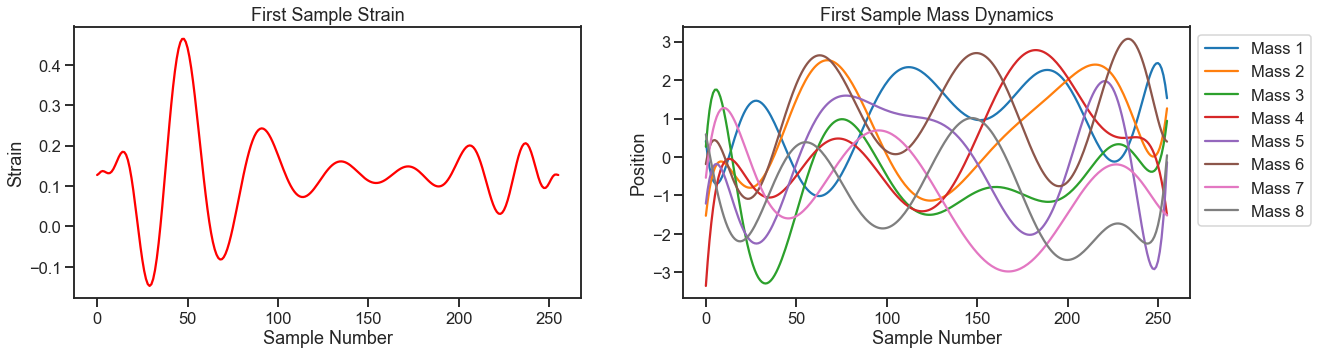

In [125]:
plt.figure(figsize = [20,5])



#Strain
plt.subplot(121)

np.shape(HTseries)

# The HTseries is a array constructed of 10000 rows and 256 columns, each row is a realisation of a strain that is 256 samples long
#
# We pick the first row (or the first sample strain) and all the rows to get a 256 sample long piece of strain we will be feeding the flow
h_sample_1 = HTseries[0,:]
np.shape(h_sample_1)

plt.title('First Sample Strain')
plt.xlabel('Sample Number')
plt.ylabel('Strain')
plt.plot(h_sample_1, color = 'r')


# Mass Dynamics
np.shape(flat_samples)

first_dynamic_source = flat_samples[0,:]
np.shape(first_mass_dynamics)
   
first_dynamics = first_dynamic_source[0:(len(first_dynamic_source)-massnum)]
first_dynamics_unflattened = first_dynamics.reshape((massnum, Order))

np.shape(first_dynamics_unflattened)

plt.subplot(122)

legend = ['Mass 1', 'Mass 2', 'Mass 3','Mass 4','Mass 5','Mass 6','Mass 7','Mass 8']
for mass in np.arange(0, massnum):
    first_source_tseries = np.polynomial.chebyshev.chebval(sample_len, first_dynamics_unflattened[mass, :])
    
    plt.plot(first_source_tseries, label = legend[mass])

plt.ylabel('Position')
plt.xlabel('Sample Number')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.title('First Sample Mass Dynamics')
plt.show()

## Same With Noise

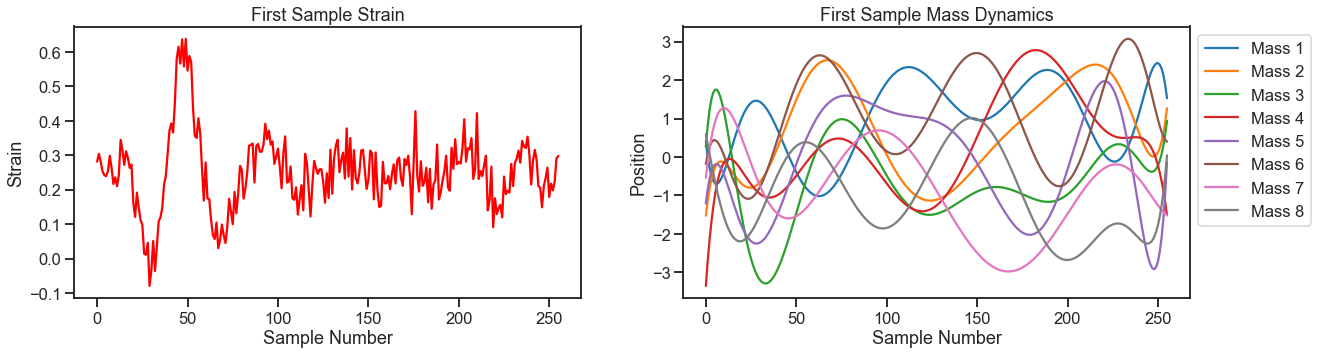

In [126]:
plt.figure(figsize = [20,5])



#Strain
plt.subplot(121)

np.shape(h_tseries_noise)

# The HTseries is a array constructed of 10000 rows and 256 columns, each row is a realisation of a strain that is 256 samples long
#
# We pick the first row (or the first sample strain) and all the rows to get a 256 sample long piece of strain we will be feeding the flow
h_sample_1_noise = h_tseries_noise[0,:]
np.shape(h_sample_1)

plt.title('First Sample Strain')
plt.xlabel('Sample Number')
plt.ylabel('Strain')
plt.plot(h_sample_1_noise, color = 'r')


# Mass Dynamics
np.shape(flat_samples)

first_dynamic_source = flat_samples[0,:]
np.shape(first_mass_dynamics)
   
first_dynamics = first_dynamic_source[0:(len(first_dynamic_source)-massnum)]
first_dynamics_unflattened = first_dynamics.reshape((massnum, Order))

np.shape(first_dynamics_unflattened)

plt.subplot(122)

legend = ['Mass 1', 'Mass 2', 'Mass 3','Mass 4','Mass 5','Mass 6','Mass 7','Mass 8']
for mass in np.arange(0, massnum):
    first_source_tseries = np.polynomial.chebyshev.chebval(sample_len, first_dynamics_unflattened[mass, :])
    
    plt.plot(first_source_tseries, label = legend[mass])

plt.ylabel('Position')
plt.xlabel('Sample Number')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.title('First Sample Mass Dynamics')
plt.show()

## SNR

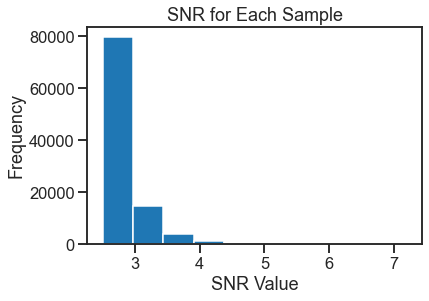

In [138]:
#SNR**2 = sum((x_j)**2) / (N * sigma**2)

sigma = 0.05
N = 256
snr = []
for n in np.arange(0, totalSamples):
    snr_squared = np.sum((HTseries[n,:])**2) / (N * sigma**2)
    snr.append(np.sqrt(snr_squared))

plt.title('SNR for Each Sample')
plt.xlabel('SNR Value')
plt.ylabel('Frequency')
plt.hist(snr)
plt.show()

# Train

In [140]:
%%time
# Variables for checkpointing
best_epoch = 0
best_val_loss = np.inf
best_model = copy.deepcopy(flow.state_dict())

# Loss
loss_dict = dict(train=[], val=[])

for n in range(n_epochs):
    
    # Train
    train_loss = 0
    flow.train()
    for batch_num,(x_tensor, labels) in enumerate(train_loader):
        x_tensor, labels = x_tensor.to('cuda'), labels.to('cuda')
        # labels = one_hot(labels, 10)
        optimiser.zero_grad()
        loss = -flow.log_prob(x_tensor, context=labels).mean()
        loss.backward()
        optimiser.step()
        train_loss += loss.cpu().detach().numpy()
    train_loss /= len(train_loader)
    loss_dict['train'].append(train_loss)
    
    # Validate
    val_loss = 0
    with torch.no_grad():
        flow.eval()
        for batch_num,(x_tensor, labels) in enumerate(test_loader):
            x_tensor, labels = x_tensor.to('cuda'), labels.to('cuda')
            # labels = one_hot(labels, 10)
            val_loss += -flow.log_prob(x_tensor, context=labels).mean().cpu().numpy()
    val_loss /= len(test_loader)

    loss_dict['val'].append(val_loss)

    # Save the best model for use at the end
    if val_loss < best_val_loss:
        best_epoch = n
        best_val_loss = val_loss
        best_model = copy.deepcopy(flow.state_dict())
        
    # Print loss every n epochs
    if not n % 5:
        print(f'{n}: Train loss: {train_loss:1.4f}')
        print(f'{n}: Val loss: {val_loss:1.4f}')
        
    # Early stopping
    if n - best_epoch > patience:
        print('Reached patience')
        break

# Load the best model
print('Finished training')
print(f'Best epoch: {best_epoch}')
print(f'Epoch {best_epoch} val loss: {best_val_loss:1.4f}')
print('Loading best model')
flow.load_state_dict(best_model)
flow.eval()

0: Train loss: 54.2226
0: Val loss: 54.4363
5: Train loss: 54.1376
5: Val loss: 54.5709
10: Train loss: 54.1089
10: Val loss: 54.4213
15: Train loss: 54.1084
15: Val loss: 55.5356
20: Train loss: 54.0940
20: Val loss: 54.0432
25: Train loss: 54.0271
25: Val loss: 54.2695
30: Train loss: 54.0267
30: Val loss: 54.3664
35: Train loss: 53.9874
35: Val loss: 54.6142
40: Train loss: 53.9481
40: Val loss: 54.4369
45: Train loss: 53.9470
45: Val loss: 54.4237
50: Train loss: 53.9292
50: Val loss: 55.4312
55: Train loss: 53.9059
55: Val loss: 55.9636
60: Train loss: 53.9024
60: Val loss: 54.0846
65: Train loss: 53.8685
65: Val loss: 54.0239
70: Train loss: 53.8500
70: Val loss: 94.3117
75: Train loss: 53.8440
75: Val loss: 54.3113
80: Train loss: 53.8346
80: Val loss: 54.8105
85: Train loss: 53.8048
85: Val loss: 67.0489
90: Train loss: 53.8298
90: Val loss: 54.1441
95: Train loss: 53.8356
95: Val loss: 54.1265
100: Train loss: 53.8129
100: Val loss: 54.7837
105: Train loss: 53.8156
105: Val lo

ImprovedRealNVP(
  (transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): CompositeTransform(
        (_transforms): ModuleList(
          (0): RandomPermutation()
          (1): LULinear()
        )
      )
      (1): BatchNorm()
      (2): AffineCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=300, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): ResidualBlock(
              (batch_norm_layers): ModuleList(
                (0): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                (1): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              )
              (context_layer): Linear(in_features=256, out_features=64, bias=True)
              (linear_layers): ModuleList(
                (0): Linear(in_features=64, out_features=64, bias=True)
                (1): Linear(in_features=64, out_features=64, bias=Tru

In [141]:
torch.save(flow.state_dict(), '/model.pt')
torch.save(optimiser.state_dict(), '/optimiser.pt')

## Loss Plots

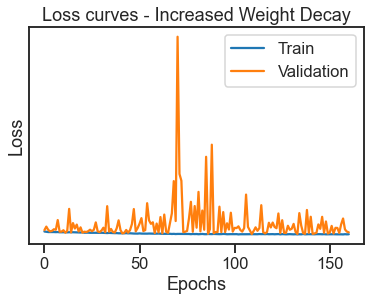

In [142]:
plt.plot(loss_dict['train'], label='Train')
plt.plot(loss_dict['val'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves - Increased Weight Decay')
plt.yscale('symlog')
plt.show()


# Sample Generation

In [54]:
with torch.no_grad():
    x, c = next(iter(test_loader))

C:\Users\User\Anaconda3\lib\site-packages\nflows\transforms\lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


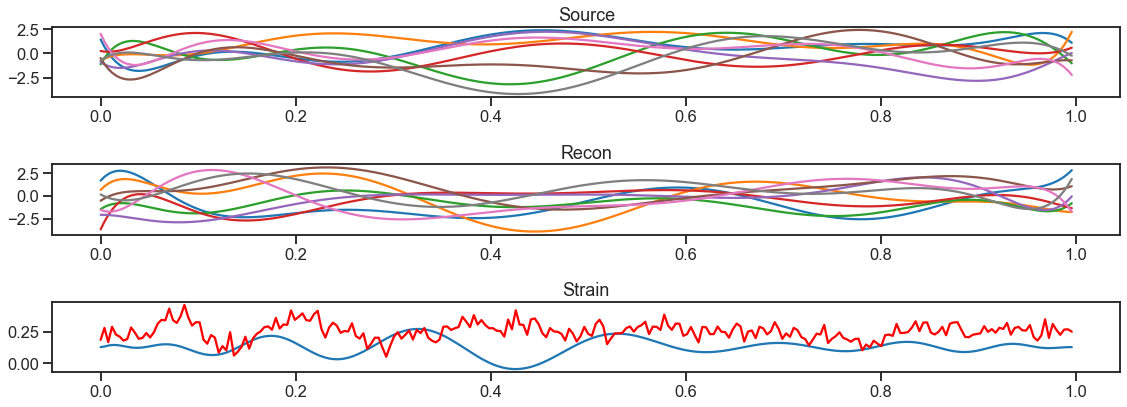

torch.Size([256])


In [55]:
with torch.no_grad():
    x = x[0].unsqueeze(0) 
    c = c[0] 
    x_out = flow.sample(1, c.unsqueeze(0).to('cuda')).cpu().numpy()
    source = x.detach().cpu().numpy().squeeze()
    
    source_dyn = source[0:(len(source)-massnum)]
    source_dyn_unflattened = source_dyn.reshape((massnum, Order))
   
    recon = x_out.squeeze()
    recon_dyn = recon[0:(len(recon)-massnum)]
    recon_dyn_unflattened = recon_dyn.reshape((massnum, Order))
    
    t = np.arange(-1,1,(2/256))
    t_shifted = np.arange(0,1,(1/256))
    c = c.cpu().squeeze()
    
    recon_summed_dyn = np.zeros(Order)
    source_summed_dyn = np.zeros(Order)
    recon_weights = recon[(len(recon)-massnum):len(recon)]
    
    source_weights = source[(len(source)-massnum):len(source)]
    overall_recon_strain = np.zeros((Order*2)-3)

    size = (16,6)
    fig, axes = plt.subplots(3, 1, figsize=size)

    for mass in range(0, massnum):
      source_tseries = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
      recon_tseries = np.polynomial.chebyshev.chebval(t, recon_dyn_unflattened[mass, :])
      axes[0].plot(t_shifted, source_tseries, label=mass)#, color='r')
      axes[1].plot(t_shifted, recon_tseries, label=mass)
      recon_summed_dyn += (recon_dyn_unflattened[mass, :] * recon_weights[mass])

    recon_coefsq = np.polynomial.chebyshev.chebpow(recon_summed_dyn, 2)
    recon_hcoefs = np.polynomial.chebyshev.chebder(recon_coefsq,2)
    recon_htseries = window * np.polynomial.chebyshev.chebval(t, recon_hcoefs)

    recon_htseries = (2*((recon_htseries - np.min(HTseries_unscaled))/(np.max(HTseries_unscaled) - np.min(HTseries_unscaled))))-1
    
    
    axes[0].set_title("Source")
    axes[1].set_title("Recon")
    axes[2].set_title("Strain")
    axes[2].plot(t_shifted, recon_htseries)
    axes[2].plot(t_shifted, c, color='r')


fig.subplots_adjust()
fig.tight_layout()
plt.show()


print(c.shape)

In [92]:
np.shape(source)

(88,)

In [56]:
c = c.unsqueeze(0)
print(c.shape)

torch.Size([1, 256])


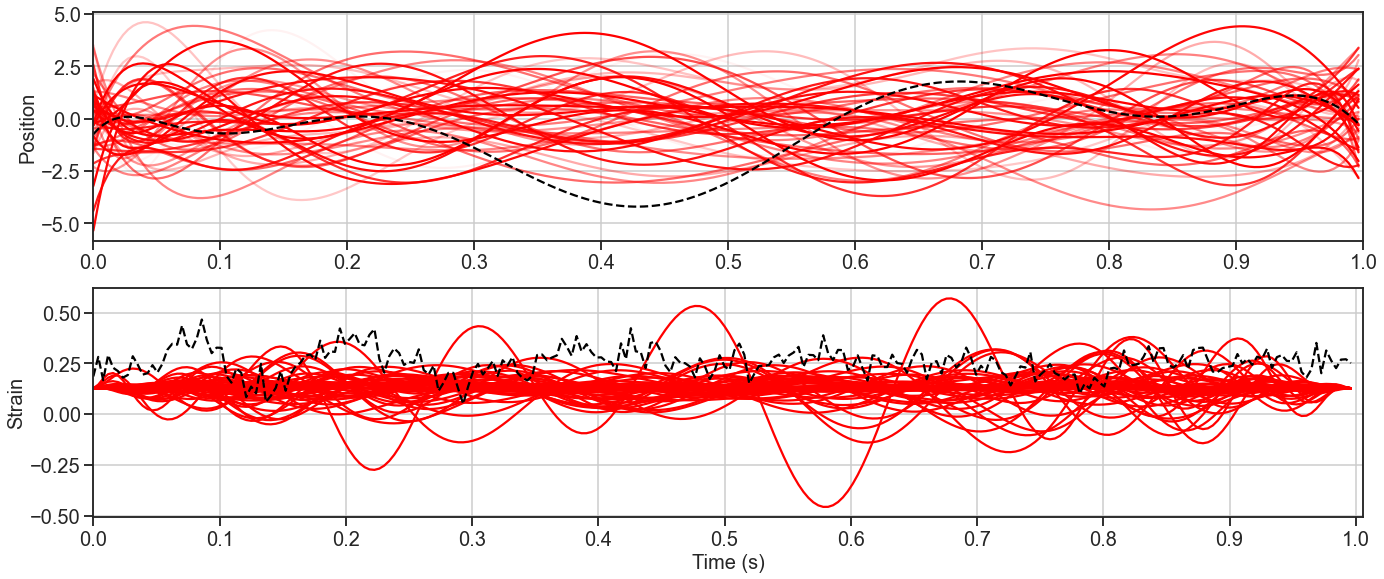

In [57]:
from matplotlib.lines import Line2D
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(19,8))
source_tseries_array = np.zeros((8,256))
t_shifted = np.arange(0,1,(1/256))
plt.setp(axes, xlim=(0,np.max(t_shifted+0.01)))


with torch.no_grad():
    for j in range (0,50):
      recon_summed_dyn = np.zeros(Order)
      x_out = flow.sample(1, c.to('cuda')).cpu().numpy()
      recon = x_out.squeeze()
      recon_dyn = recon[0:(len(recon)-massnum)]
      recon_unflattened_dyn = recon_dyn.reshape((massnum, Order))
      recon_weights = recon[(len(recon)-massnum):len(recon)]
      recon_weights_rescaled = (0.95*((recon_weights - np.min(recon_weights))/(np.max(recon_weights) - np.min(recon_weights))))+0.05
      source_weights_rescaled = (0.95*((source_weights - np.min(source_weights))/(np.max(source_weights) - np.min(source_weights))))+0.05
      for mass in range(0, 8):
        #Use random latent space point z to produce multiple possible dynamics for a single strain
        recon_tseries = np.polynomial.chebyshev.chebval(t, recon_unflattened_dyn[mass, :])
    
        if mass == 0:
          axes[mass].plot(t_shifted, recon_tseries, color='r', alpha = recon_weights_rescaled[mass])
          axes[mass].set_xlim([0, np.max(t_shifted)])
        recon_summed_dyn += (recon_unflattened_dyn[mass, :] * recon_weights[mass])

      x_coefsq = np.polynomial.chebyshev.chebpow(recon_summed_dyn, 2)
      x_hcoefs = np.polynomial.chebyshev.chebder(x_coefsq,2)
      recon_htseries = window * np.polynomial.chebyshev.chebval(t, x_hcoefs)
      recon_htseries = (2*((recon_htseries - np.min(HTseries_unscaled))/(np.max(HTseries_unscaled) - np.min(HTseries_unscaled))))-1
        
      axes[1].plot(t_shifted, recon_htseries, 'r')
    axes[1].plot(t_shifted, c.squeeze(), color='k', ls='--')
    

    for mass in range(0, 8):
      source_tseries_array[mass,:] = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
      source_tseries = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
    axes[0].plot(t_shifted, source_tseries, 'k--')
      

    
    
    fig.subplots_adjust()
    fig.tight_layout()
    axes[0].set_xticks(np.arange(0,1.01,0.1))
    axes[1].set_xticks(np.arange(0,1.01,0.1))
    axes[0].tick_params(axis='both', which='major', labelsize=20)
    axes[1].tick_params(axis='both', which='major', labelsize=20)
    axes[0].grid(b=bool)
    axes[1].grid(b=bool)
    # axes[0].set_xlabel('Time (s)', fontsize=20)
    axes[1].set_xlabel('Time (s)', fontsize=20)
    axes[0].set_ylabel('Position', fontsize=20)
    axes[1].set_ylabel('Strain', fontsize=20)
    plt.show()

# Animation

In [58]:
%matplotlib inline

In [59]:
from matplotlib import animation, rc
from IPython.display import HTML

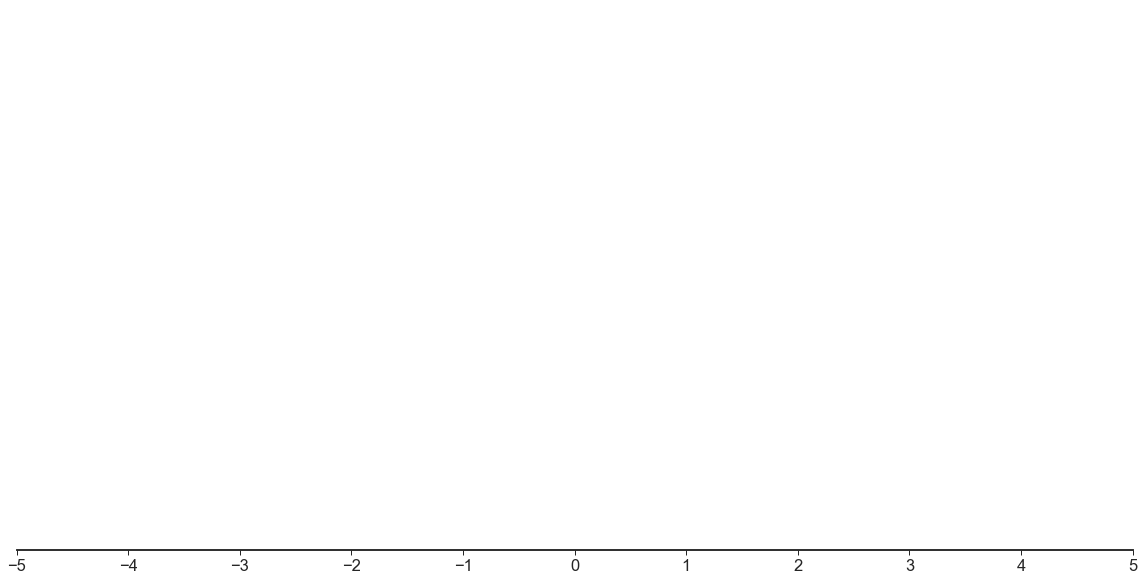

In [60]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(20,10))

ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(which='major', width=1.00)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', width=0.75)
ax.tick_params(which='minor', length=2.5)
ax.set_xlim(-5,5)
ax.set_ylim(0,1)
ax.patch.set_alpha(0.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.NullLocator())
plt.gca()
ax.set_facecolor((0.5, 0.5, 0.5))
scat = ax.scatter([[]],[[]], cmap='hsv', alpha=0.6)


In [61]:
#source_tseries_array

def init():
    scat = ax.scatter([[]],[[]],cmap='hsv', alpha=0.6)
    return scat,


In [62]:
def animate(i):
  scat.set_offsets(np.vstack((source_tseries_array[:, i], [0.07]*8)).T)
  scat.set_sizes(source_weights * 20000)
  scat.set_array(np.arange(8))
  return scat,

In [63]:
# call the animator. blit=True means only re-draw the parts that have changed
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=256, interval=40)

In [64]:
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available